Tim Wang
zilinwan

In [53]:
from math import *
from numpy import *
from scipy.constants import *
from scipy import linalg
from scipy.interpolate import interp1d
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import scipy.fftpack as fft
from scipy.fftpack import *

# Constants
L = 1.0
R = L/4
Np = 32**3
Nc = 128
Ms = 0.1*Np
t_dyn = math.sqrt((pi**2)*(R**3)/(4*G*Ms))

# Initialize (Initial Conditions)

def init():
    particles = np.zeros((9,Np))

    for i in range(Np):
        u = np.random.random_sample()
        phi = 2*pi*u
        u = np.random.random_sample()
        r = (3*u*(R**3)/3)**(1/3)
        u = np.random.random_sample()
        theta = acos(2*u-1)
        
        x = r*sin(theta)*cos(phi)
        y = r*sin(theta)*sin(phi)
        z = r*cos(theta)


        particles[0,i] = 0.5+x
        particles[1,i] = 0.5+y
        particles[2,i] = 0.5+z
    
    return particles
print("Done")


Done


In [54]:
# Generate Cloud in Cell percentages

def CIC(x,y,z):
    
    xden = np.zeros((3,3,3))
    yden = np.zeros((3,3,3))
    zden = np.zeros((3,3,3))
    density = np.zeros((3,3,3))

    n = x/(1/Nc)
    xindex = math.floor(n)
    midpoint = xindex*(1/Nc)+(1/(Nc*2))
    if (x < midpoint):
        dx1 = (1/(Nc*2))-(x-xindex*(1/Nc))
        xden[0,:,:] = dx1
        dx2 = (1/(Nc*2))+(x-xindex*(1/Nc))
        xden[1,:,:] = dx2
    else:
        dx1 = (1/(Nc*2))-((xindex+1)*(1/Nc)-x)
        xden[2,:,:] = dx1
        dx2 = (1/(Nc*2))+((xindex+1)*(1/Nc)-x)
        xden[1,:,:] = dx2
        
    n = y/(1/Nc)
    yindex = math.floor(n)
    midpoint = yindex*(1/Nc)+(1/(Nc*2))
    if (y < midpoint):
        dy1 = (1/(Nc*2))-(y-yindex*(1/Nc))
        yden[:,0,:] = dy1
        dy2 = (1/(Nc*2))+(y-yindex*(1/Nc))
        yden[:,1,:] = dy2
    else:
        dy1 = (1/(Nc*2))-((yindex+1)*(1/Nc)-y)
        yden[:,2,:] = dy1
        dy2 = (1/(Nc*2))+((yindex+1)*(1/Nc)-y)
        yden[:,1,:] = dy2
        
    n = z/(1/Nc)
    zindex = math.floor(n)
    midpoint = zindex*(1/Nc)+(1/(Nc*2))
    if (z < midpoint):
        dz1 = (1/(Nc*2))-(z-zindex*(1/Nc))
        zden[:,:,0] = dz1
        dz2 = (1/(Nc*2))+(z-zindex*(1/Nc))
        zden[:,:,1] = dz2
    else:
        dz1 = (1/(Nc*2))-((zindex+1)*(1/Nc)-z)
        zden[:,:,2] = dz1
        dz2 = (1/(Nc*2))+((zindex+1)*(1/Nc)-z)
        zden[:,:,1] = dz2
    density = xden*yden*zden
    density = density/((1/Nc)**3)    
    
    return xindex,yindex,zindex,density

print("Done")

Done


In [55]:
# Fourier Transformation and Finite Difference

def wave_vector(x,y,z):
    k = np.zeros(3)
    if x <= Nc/2:
        k[0] = (2*pi/Nc)*x
    else:
        k[0] = (2*pi/Nc)*(x-Nc)
    if y <= Nc/2:
        k[1] = (2*pi/Nc)*y
    else:
        k[1] = (2*pi/Nc)*(y-Nc)
    if z <= Nc/4:
        k[2] = (2*pi/((Nc/2)+1))*z
    else:
        k[2] = (2*pi/((Nc/2)+1))*(z-((Nc/2)+1))
        
    return k

def kernal_fxn(k):
    return -4*pi*G/(((2*sin(k[0]/2))**2) + ((2*sin(k[1]/2))**2) + ((2*sin(k[2]/2))**2))

def kernal():
    w = np.zeros((Nc,Nc,(int)((Nc/2)+1)))
    for i in range(Nc):
        for j in range(Nc):
            for m in range((int)((Nc/2)+1)):
                if (i == 0 and j == 0 and m == 0):
                    w[i,j,m] = 0
                else:
                    k = wave_vector(i,j,m)
                    w[i,j,m] = kernal_fxn(k)
    return w

w = kernal()

def finite_difference(phi,x,y,z):
    
    h = 1/Nc
    result = np.zeros(3)
    if (x == 0):
        result[0] = (phi[x+1,y,z]-phi[x,y,z])/h
    elif (x == Nc-1):
        result[0] = (phi[x,y,z]-phi[x-1,y,z])/h
    else:
        result[0] = (phi[x+1,y,z]-phi[x-1,y,z])/(2*h)
        
    if (y == 0):
        result[1] = (phi[x,y+1,z]-phi[x,y,z])/h
    elif (y == Nc-1):
        result[1] = (phi[x,y,z]-phi[x,y-1,z])/h
    else:
        result[1] = (phi[x,y+1,z]-phi[x,y-1,z])/(2*h)
    
    if (z == 0):
        result[2] = (phi[x,y,z+1]-phi[x,y,z])/h
    elif (z == Nc-1):
        result[2] = (phi[x,y,z]-phi[x,y,z-1])/h
    else:
        result[2] = (phi[x,y,z+1]-phi[x,y,z-1])/(2*h)
        
    return result
print("Done")


Done


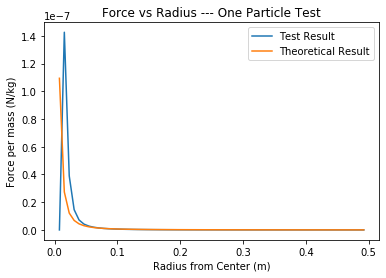

In [57]:
# One Particle Test

mesh_one = np.zeros((Nc,Nc,Nc))

x = 64*(1/Nc)+1/(Nc*2)
y = 64*(1/Nc)+1/(Nc*2)
z = 64*(1/Nc)+1/(Nc*2)

result = CIC(x,y,z)
xindex = result[0]
yindex = result[1]
zindex = result[2]
density = result[3]
density = density*0.1
for i in range(3):
        for j in range(3):
            for k in range(3):
                mesh_one[xindex-1+i,yindex-1+j,zindex-1+k] += density[i,j,k]

density_fft = np.fft.rfftn(mesh_one)
product = density_fft*w
potential = np.fft.irfftn(product)/((1/Nc))

accel = np.zeros((Nc,Nc,Nc,3))

for i in range(Nc):
    for j in range(Nc):
        for k in range(Nc):
            accel[i,j,k] = finite_difference(potential,i,j,k)

rad = np.zeros(Nc-xindex-1)
f = np.zeros(Nc-xindex-1)

i = xindex
while i < Nc-1:
    rad[i-xindex] = (1/Nc)*(i-xindex+1)
    f[i-xindex] = math.sqrt(accel[i,yindex,zindex,0]**2) 
    i+=1
plt.title("Force vs Radius --- One Particle Test")
plt.plot(rad,f,label = "Test Result")
plt.plot(rad,G*0.1/(rad**2),label = "Theoretical Result")
plt.xlabel("Radius from Center (m)")
plt.ylabel("Force per mass (N/kg)")
plt.legend()
plt.show()

In [58]:
# Force interpolation (finding accleration from particle position)

def find_accel(particles):
    mesh = np.zeros((Nc,Nc,Nc))
    
    for m in range(Np):
        x = particles[0,m]
        y = particles[1,m]
        z = particles[2,m]
        result = CIC(x,y,z)
        xindex = result[0]
        yindex = result[1]
        zindex = result[2]
        density = result[3]
        density = 0.1*density
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    mesh[xindex-1+i,yindex-1+j,zindex-1+k] += density[i,j,k]

    density_fft = np.fft.rfftn(mesh)
    product = density_fft*w
    potential = np.fft.irfftn(product)/(1/Nc)
    accel = np.zeros((Nc,Nc,Nc,3))

    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                accel[i,j,k] = -1*finite_difference(potential,i,j,k)

    for m in range(Np):
        x = particles[0,m]
        y = particles[1,m]
        z = particles[2,m]
        result = CIC(x,y,z)
        xindex = result[0]
        yindex = result[1]
        zindex = result[2]
        percentage = result[3]
        f = np.zeros(3)
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    f += accel[xindex-1+i,yindex-1+j,zindex-1+k]*percentage[i,j,k]
        particles[6,m] = f[0]
        particles[7,m] = f[1]
        particles[8,m] = f[2]

    return particles

    

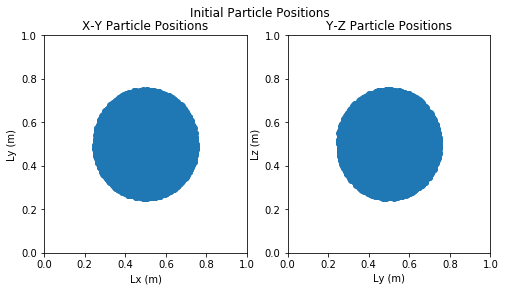

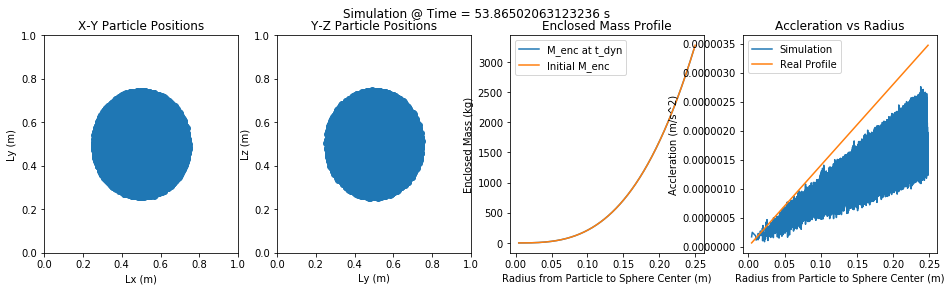

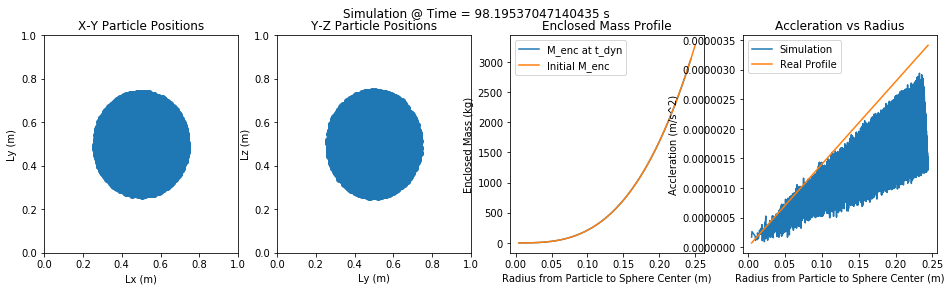

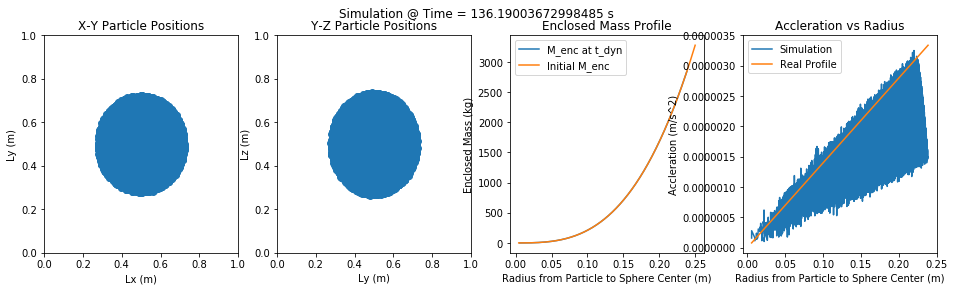

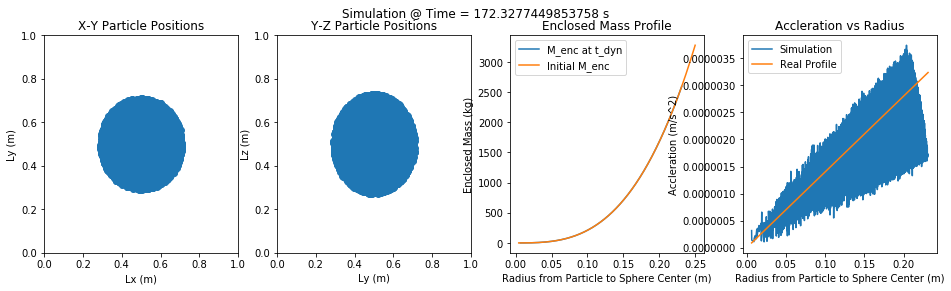

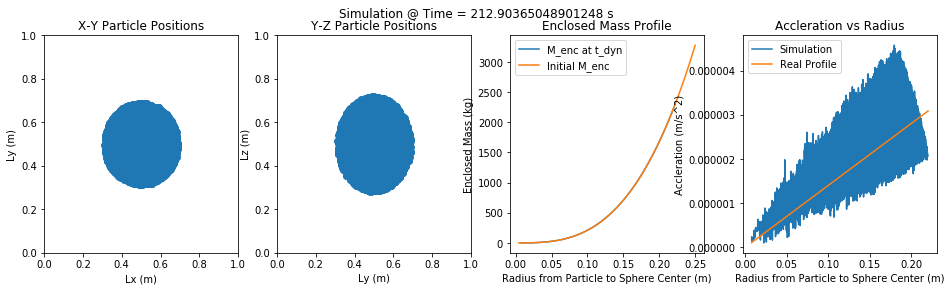

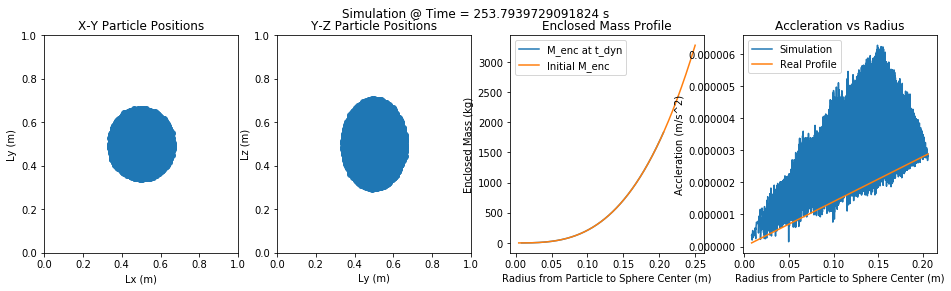

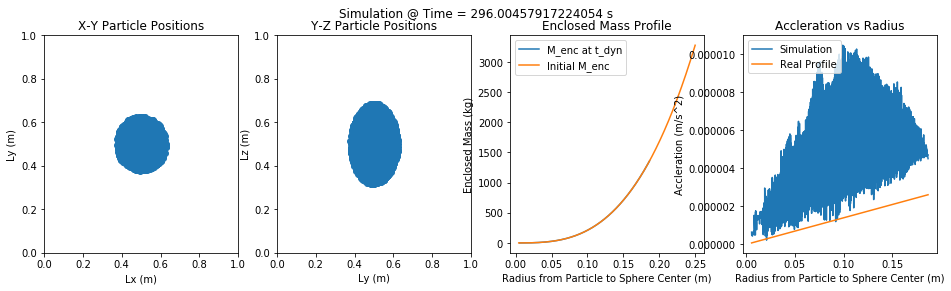

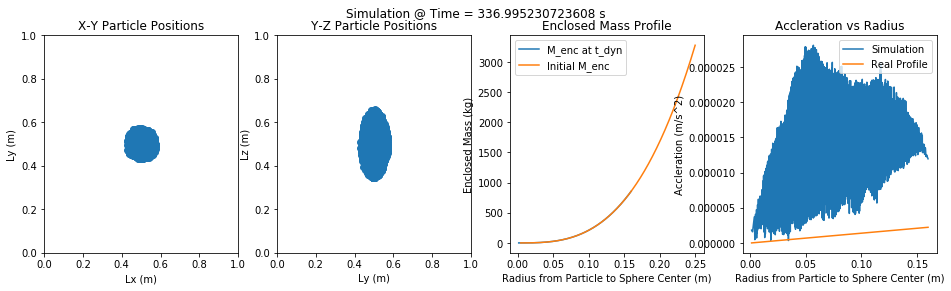

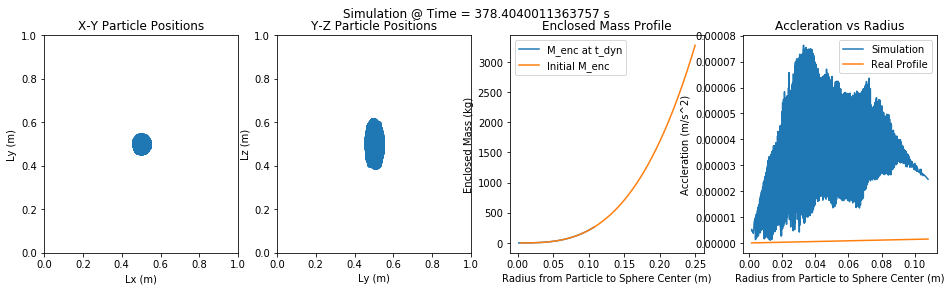

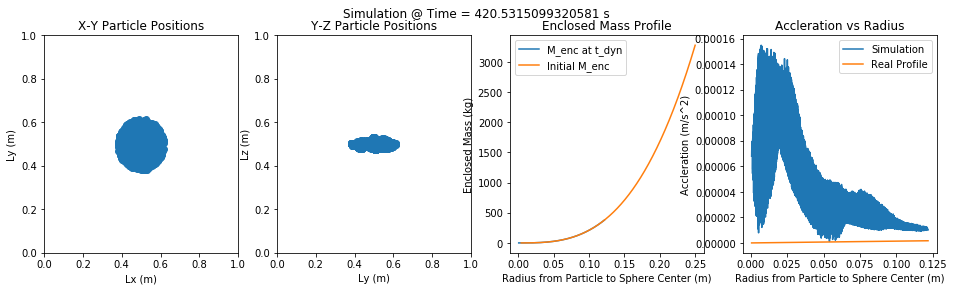

Done


In [61]:
# Verlet and Gravitational Collapse Simulation

def m_enc(r):
    return Ms*((r/R)**3)
def avg_accel(r):
    return G*m_enc(r)/(r**2)

t_dyn = math.sqrt((pi**2)*(R**3)/(4*G*Ms))
t = 0
particles = init()
particles = find_accel(particles)

plt.figure(figsize = (8,4))
        
plt.subplot(121)
plt.scatter(particles[0],particles[1])
xlim = 0
ylim = 1
plt.xlim(xlim,ylim)
plt.ylim(xlim,ylim)
plt.xlabel("Lx (m)")
plt.ylabel("Ly (m)")
plt.title("X-Y Particle Positions")
        
plt.subplot(122)
plt.scatter(particles[1],particles[2])
plt.xlim(xlim,ylim)
plt.ylim(xlim,ylim)
plt.xlabel("Ly (m)")
plt.ylabel("Lz (m)")
plt.title("Y-Z Particle Positions")

plt.suptitle("Initial Particle Positions")
plt.show()

r_tot_init = np.zeros(Np)
for i in range(Np):
    r_tot_init[i] = math.sqrt(((particles[0,i]-0.5)**2) + ((particles[1,i]-0.5)**2) + ((particles[2,i]-0.5)**2))
r_tot_init = np.sort(r_tot_init)
n = 0.1

while t < t_dyn:

    v_tot = np.zeros(Np)
    a_tot = np.zeros(Np)
    
    for i in range(Np):
        v_tot[i] = math.sqrt((particles[3,i]**2) + (particles[4,i]**2) + (particles[5,i]**2))
        a_tot[i] = math.sqrt((particles[6,i]**2) + (particles[7,i]**2) + (particles[8,i]**2))
    max_v = np.amax(v_tot)
    max_a = np.amax(a_tot)
    
    if (max_v == 0):
        h = 0.5*math.sqrt((1/Nc)/np.amax(a_tot))
    elif(max_a == 0):
        h = 0.5*(1/Nc)/np.amax(v_tot)
    else:
        h = 0.5*min((1/Nc)/np.amax(v_tot),math.sqrt((1/Nc)/np.amax(a_tot)))

    dx = particles[0]
    dy = particles[1]
    dz = particles[2]
    vx = particles[3]
    vy = particles[4]
    vz = particles[5]
    ax = particles[6]
    ay = particles[7]
    az = particles[8]

    vx_half = vx + ax*h*0.5
    dx = dx + vx_half * h
    vy_half = vy + ay*h*0.5
    dy = dy + vy_half * h
    vz_half = vz + az*h*0.5
    dz = dz + vz_half * h
    
    particles[0] = dx
    particles[1] = dy
    particles[2] = dz
    particles = find_accel(particles)
    
    ax = particles[6]
    ay = particles[7]
    az = particles[8]
    
    vx = vx_half + ax*h/2
    vy = vy_half + ay*h/2
    vz = vz_half + az*h/2

    particles[0] = dx
    particles[1] = dy
    particles[2] = dz
    particles[3] = vx
    particles[4] = vy
    particles[5] = vz
    particles[6] = ax
    particles[7] = ay
    particles[8] = az


    t += h
    if ((t/t_dyn) > n):
        
        plt.figure(figsize = (16,4))
        
        plt.subplot(141)
        plt.scatter(particles[0],particles[1])
        plt.xlim(xlim,ylim)
        plt.ylim(xlim,ylim)
        plt.xlabel("Lx (m)")
        plt.ylabel("Ly (m)")
        plt.title("X-Y Particle Positions")
        
        plt.subplot(142)
        plt.scatter(particles[1],particles[2])
        plt.xlim(xlim,ylim)
        plt.ylim(xlim,ylim)
        plt.xlabel("Ly (m)")
        plt.ylabel("Lz (m)")
        plt.title("Y-Z Particle Positions")
        
        r_tot = np.zeros(Np)
        for i in range(Np):
            r_tot[i] = math.sqrt(((particles[0,i]-0.5)**2) + ((particles[1,i]-0.5)**2) + ((particles[2,i]-0.5)**2))
        r_sort = np.sort(r_tot)
        a_tot = np.zeros(Np)
        for i in range(Np):
            a_tot[i] = math.sqrt((particles[6,i]**2) + (particles[7,i]**2) + (particles[8,i]**2))
        
        plt.subplot(143)
        plt.plot(r_sort,m_enc(r_sort),label = "M_enc at t_dyn")
        plt.plot(r_tot_init,m_enc(r_tot_init),label = "Initial M_enc")
        plt.xlabel("Radius from Particle to Sphere Center (m)")
        plt.ylabel("Enclosed Mass (kg)")
        plt.title("Enclosed Mass Profile")
        plt.legend()
        
        binsort = np.zeros((2,Np))
        binsort[0] = r_tot
        binsort[1] = a_tot
        binsort = binsort[:,binsort[0].argsort()]

        r_tot = binsort[0]
        a_tot = binsort[1]
        
        plt.subplot(144)
        plt.plot(r_tot,a_tot,label = "Simulation")
        plt.plot(r_tot,avg_accel(r_tot), label = "Real Profile")
        plt.xlabel("Radius from Particle to Sphere Center (m)")
        plt.ylabel("Accleration (m/s^2)")
        plt.title("Accleration vs Radius")
        plt.legend()
        
        plt.suptitle("Simulation @ Time = " + str(t) + " s")
        plt.show()
        n += 0.1

        
print("Done")

Gravitational Collapse usually occurs for a uniformly distrubuted system, because such a system has a center of gravity towards which the particles collapse towards.
Under the influence of their "collective" gravity, they fall towards the center to form a denser and denser distrubtion of matter. Once it reaches t_dyn, the system
stops collapsing. After t_dyn, the system begins to expand due to the pressure exerted outwards from the dense distrubtion inside. Such process is how a typical star
or a galaxy is formed.

The resolution limitations of PM lie within the calculation of density. PM grids approximate density only to a precision that depends on the cell length, and therefore the density field would not be exactly continuous.

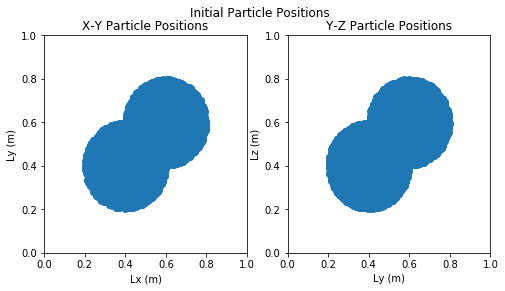

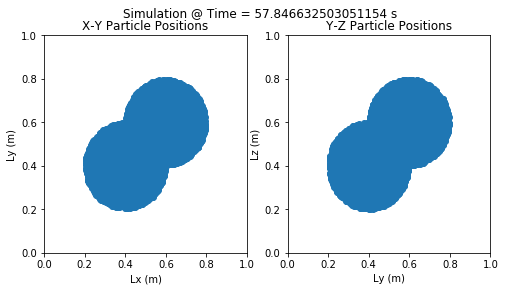

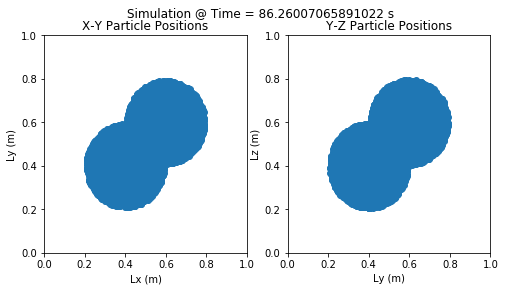

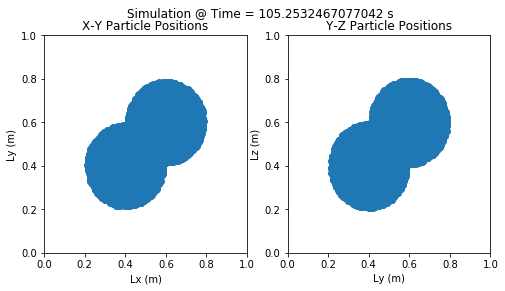

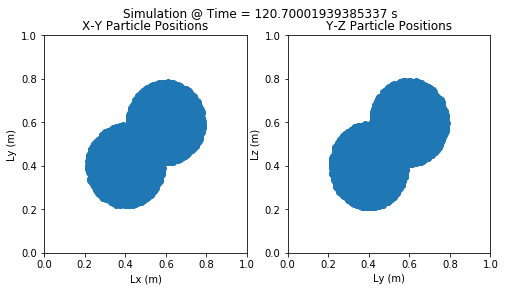

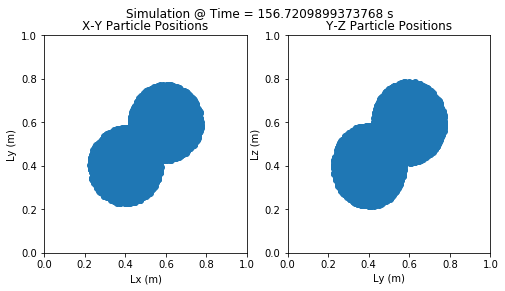

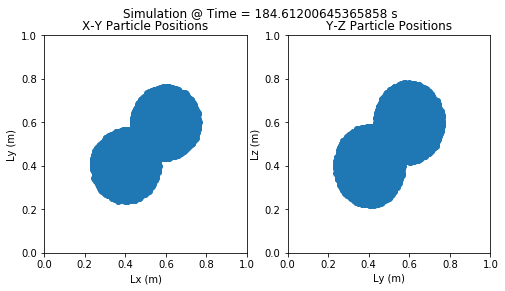

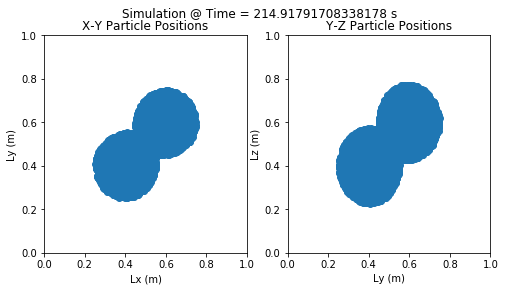

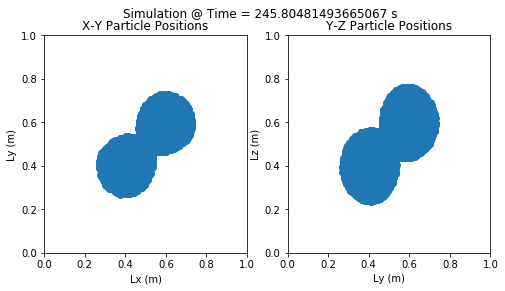

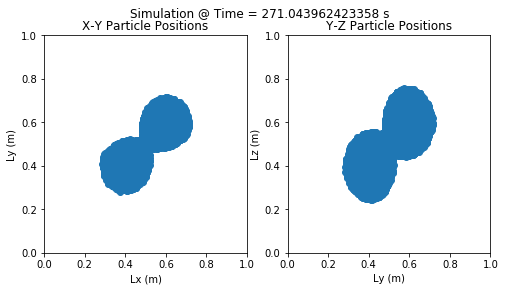

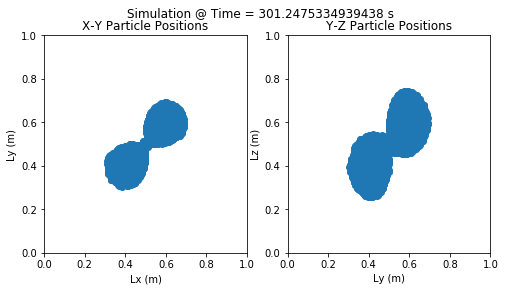

In [66]:
# Independent
# Mixed Sphere
R = L/5

def independent():
    particles = np.zeros((9,Np))

    for i in range((int)(Np/2)):
        u = np.random.random_sample()
        phi = 2*pi*u
        u = np.random.random_sample()
        r = (3*u*(R**3)/3)**(1/3)
        u = np.random.random_sample()
        theta = acos(2*u-1)
        
        x = r*sin(theta)*cos(phi)
        y = r*sin(theta)*sin(phi)
        z = r*cos(theta)


        particles[0,i] = 0.6+x
        particles[1,i] = 0.6+y
        particles[2,i] = 0.6+z
        

    for i in range((int)(Np/2),Np):
        u = np.random.random_sample()
        phi = 2*pi*u
        u = np.random.random_sample()
        r = (3*u*(R**3)/3)**(1/3)
        u = np.random.random_sample()
        theta = acos(2*u-1)
        
        x = r*sin(theta)*cos(phi)
        y = r*sin(theta)*sin(phi)
        z = r*cos(theta)


        particles[0,i] = 0.4+x
        particles[1,i] = 0.4+y
        particles[2,i] = 0.4+z
    
    return particles


t_dyn = math.sqrt((pi**2)*(R**3)/(4*G*Ms))
t = 0
particles = independent()
particles = find_accel(particles)
plt.figure(figsize = (8,4))
        
plt.subplot(121)
plt.scatter(particles[0],particles[1])
xlim = 0
ylim = 1
plt.xlim(xlim,ylim)
plt.ylim(xlim,ylim)
plt.xlabel("Lx (m)")
plt.ylabel("Ly (m)")
plt.title("X-Y Particle Positions")
        
plt.subplot(122)
plt.scatter(particles[1],particles[2])
plt.xlim(xlim,ylim)
plt.ylim(xlim,ylim)
plt.xlabel("Ly (m)")
plt.ylabel("Lz (m)")
plt.title("Y-Z Particle Positions")

plt.suptitle("Initial Particle Positions")
plt.show()

r_tot_init = np.zeros(Np)
for i in range(Np):
    r_tot_init[i] = math.sqrt(((particles[0,i]-0.5)**2) + ((particles[1,i]-0.5)**2) + ((particles[2,i]-0.5)**2))
r_tot_init = np.sort(r_tot_init)
n = 0.1

while t < t_dyn:

    v_tot = np.zeros(Np)
    a_tot = np.zeros(Np)
    
    for i in range(Np):
        v_tot[i] = math.sqrt((particles[3,i]**2) + (particles[4,i]**2) + (particles[5,i]**2))
        a_tot[i] = math.sqrt((particles[6,i]**2) + (particles[7,i]**2) + (particles[8,i]**2))
    max_v = np.amax(v_tot)
    max_a = np.amax(a_tot)
    
    if (max_v == 0):
        h = 0.5*math.sqrt((1/Nc)/np.amax(a_tot))
    elif(max_a == 0):
        h = 0.5*(1/Nc)/np.amax(v_tot)
    else:
        h = 0.5*min((1/Nc)/np.amax(v_tot),math.sqrt((1/Nc)/np.amax(a_tot)))

    dx = particles[0]
    dy = particles[1]
    dz = particles[2]
    vx = particles[3]
    vy = particles[4]
    vz = particles[5]
    ax = particles[6]
    ay = particles[7]
    az = particles[8]

    vx_half = vx + ax*h*0.5
    dx = dx + vx_half * h
    vy_half = vy + ay*h*0.5
    dy = dy + vy_half * h
    vz_half = vz + az*h*0.5
    dz = dz + vz_half * h
    
    particles[0] = dx
    particles[1] = dy
    particles[2] = dz
    particles = find_accel(particles)
    
    ax = particles[6]
    ay = particles[7]
    az = particles[8]
    
    vx = vx_half + ax*h/2
    vy = vy_half + ay*h/2
    vz = vz_half + az*h/2

    particles[0] = dx
    particles[1] = dy
    particles[2] = dz
    particles[3] = vx
    particles[4] = vy
    particles[5] = vz
    particles[6] = ax
    particles[7] = ay
    particles[8] = az


    t += h
    if ((t/t_dyn) > n):
        
        plt.figure(figsize = (8,4))
        
        plt.subplot(121)
        plt.scatter(particles[0],particles[1])
        plt.xlim(xlim,ylim)
        plt.ylim(xlim,ylim)
        plt.xlabel("Lx (m)")
        plt.ylabel("Ly (m)")
        plt.title("X-Y Particle Positions")
        
        plt.subplot(122)
        plt.scatter(particles[1],particles[2])
        plt.xlim(xlim,ylim)
        plt.ylim(xlim,ylim)
        plt.xlabel("Ly (m)")
        plt.ylabel("Lz (m)")
        plt.title("Y-Z Particle Positions")
        
        plt.suptitle("Simulation @ Time = " + str(t) + " s")
        plt.show()
        n += 0.1

The sub-spheres still shrink, and they seem to be shrinking with little regards to the other sphere. As time passes, the spheres eventually detach.
The particles are still drawn to the uniform center of gravity. The particles near the center of the shared region can potentially go towards either center.